Author: Parth S. Shah

In [161]:
# Import all the necessary modules first. Note that we will use the python in-built function for minimization
from qiskit import BasicAer, execute, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [162]:
# Define the global parameters
theta_x = Parameter("theta_x")
theta_y = Parameter("theta_y")
backend = BasicAer.get_backend("qasm_simulator")
shots = 1

Here we define the noise model. Note that this code was picked up from the Qiskit Textbook with not many changes

In [163]:
# Example error probabilities
p_reset = 0.3
p_meas = 0.1
p_gate1 = 0.1

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

Here we define the basic circuit. This "ansatz" was arrived at by realising that we want only a superposition of the $|01>$ and $|10>$ states only. It is easy to verify that the Rx Ry gates on the 1st qubit alone can take it to any point on the Bloch Sphere within a phase factor. After that we entangle it with the CNOT gate with the other qubit in $|1>$ initially. This gives us any superposition of the 2 states mentioned earlier.

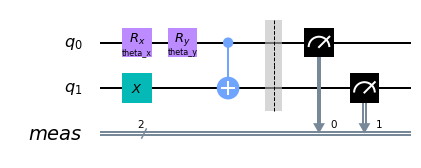

In [219]:
# Define the Quantum circuit to be used
qc = QuantumCircuit(2)
qc.rx(theta_x, 0)
qc.ry(theta_y, 0)
qc.x(1)
qc.cx(0, 1)
qc.measure_all()
# Define a circuit to verify our values later.
q_verif = qc.copy()

qc.draw("mpl")

Here we define a cost function of our own. We try to penalise probabilities of other states and penalise a probability of the required state away from 0.5.

In [165]:
def cost1(p_dict):
    try:
        p_01 = p_dict["01"]/shots
    except:
        p_01 = 0
    try:
        p_10 = p_dict["10"]/shots
    except:
        p_10 = 0 
    try:
        p_11 = p_dict["11"]/shots
    except:
        p_11 = 0
    try:
        p_00 = p_dict["00"]/shots
    except:
        p_00 = 0
    c = (p_01-0.5)**2 + (p_10-0.5)**2 + p_00 + p_11
    return c

In [166]:
# Function to run the circuit and return the cost 
def run_circuit1(angles):
    p_dict = execute(qc.bind_parameters({theta_x:angles[0], theta_y:angles[1]}), backend = qasm_backend, shots = shots, basis_gates=noise_bit_flip.basis_gates).result().get_counts()
    # print(p_dict)
    return cost1(p_dict)

In [224]:
tol = 1e-3
# Use different shots as given in the question.
for i in np.logspace(0, 3, 4):  
    shots  = i
    # Use the minimise function
    optimum_value = minimize(run_circuit1, [0,0], method="powell", tol=tol)
    opt_x, opt_y = optimum_value.x[0:2]
    print("Shots = ", shots, "Final x angle = ",opt_x, "Final y angle = ",opt_y, "Least cost = ",optimum_value.fun)

Shots =  1.0 Final x angle =  2.2360679652352626 Final y angle =  2.2360679652352626 Least cost =  0.5
Shots =  10.0 Final x angle =  -11.15541703082923 Final y angle =  -7.3339389528432175 Least cost =  0.01999999999999999
Shots =  100.0 Final x angle =  1.3696647219200178 Final y angle =  2.9126504084473153 Least cost =  0.00020000000000000036
Shots =  1000.0 Final x angle =  1.6117041116272177 Final y angle =  0.1028565378179253 Least cost =  2.0000000000000037e-06


As can be seen the error reduces with more shots. Note that the values obtained should actually be wrapped around by 2$\pi$

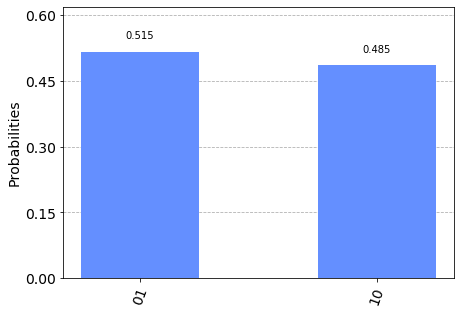

In [229]:
# Just verify with the copy of the circuit to show the probability distribution. As can be seen it's close to 0.5
p_dict = execute(q_verif.bind_parameters({theta_x:opt_x, theta_y:opt_y}), backend = backend, shots = shots, basis_gates=noise_bit_flip.basis_gates).result().get_counts()

plot_histogram(p_dict)

The following code is for the bonus task mentioned in the quesion. As can be seen the cost function has changed and so has the circuit that we are optimising. The circuit has and additional "inverse bell circuit" which rotates the $\frac{|01>+|10>}{\sqrt{2}}$ to the state $|01>$.

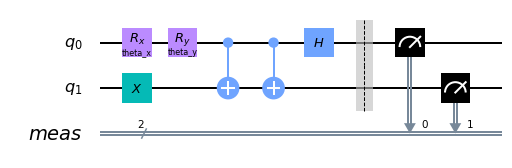

In [233]:
qc = QuantumCircuit(2)

def cost(p_dict):
    try:
        p_01 = p_dict["01"]/shots
    except:
        p_01 = 0
    try:
        p_10 = p_dict["10"]/shots
    except:
        p_10 = 0 
    try:
        p_11 = p_dict["11"]/shots
    except:
        p_11 = 0
    try:
        p_00 = p_dict["00"]/shots
    except:
        p_00 = 0
    # New cost function. Don't need square anymore since the probability is always between 0 and 1. Again penalise the other states
    # Note the qiskit ordering here. Need to use "10" instead of "01"
    c = 1 - p_10 + p_01 + p_00 + p_11
    return c

def run_circuit(angles):
    p_dict = execute(qc.bind_parameters({theta_x:angles[0], theta_y:angles[1]}), backend = backend, shots = shots).result().get_counts()
    return cost(p_dict)

qc.rx(theta_x, 0)
qc.ry(theta_y, 0)
qc.x(1)
qc.cx(0, 1)
# The additional "inverse bell" circuit
qc.cx(0, 1)
qc.h(0)

qc.measure_all()
qc.draw("mpl")


In [234]:
tol = 1e-2 
optimum_value = minimize(run_circuit, [0,0], method="powell", tol=tol)
opt_x, opt_y = optimum_value.x[0:2]
print("Final x angle = ",opt_x, "Final y angle = ",opt_y, "Least cost = ",optimum_value.fun)

Final x angle =  3.1095537377452307 Final y angle =  -1.6266752046497328 Least cost =  0.0


Values obtained are close the expected values of either $\pi$ and $-\pi/2$ or $0$ and $\pi/2$. Difference is probably due to noise.

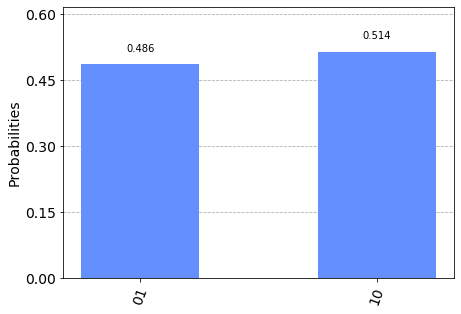

In [235]:
# Verifying that we got half and half for the 2 states
q_verif = QuantumCircuit(2)
q_verif.rx(theta_x, 0)
q_verif.ry(theta_y, 0)
q_verif.x(1)
q_verif.cx(0, 1)
q_verif.measure_all()
q_verif.draw()

p_dict = execute(q_verif.bind_parameters({theta_x:opt_x, theta_y:opt_y}), backend = backend, shots = shots, basis_gates=noise_bit_flip.basis_gates).result().get_counts()

plot_histogram(p_dict)